# Flopy Tutorial 3: Transient Model With River

This script will create a single-layer, confined aquifer in flopy and use MODFLOW-2005 to run a transient simulation of groundwater flow in a 1000m x 1000m domain with general head boundaries on the left and right edges of the aquifer and a river in the center with a stage that varies transiently.
<img src="https://i.imgur.com/gZmLstK.png" title="Transient River Model" width=600px /></a>

This tutorial focuses on the MODFLOW RIV & CHD packages and the differences between the transient steps vs the steady-state model created in "Flopy Tutorial 1". Similar aspects to Tutorial 1 will be created very quickly. If you don't understand what part of the code is doing, feel free to go back to that notebook to review what's happening.

Resources:
- <strong>Flopy Documentation: </strong>http://modflowpy.github.io/flopydoc/
- <strong>MODFLOW Online Documentation: </strong>https://water.usgs.gov/nrp/gwsoftware/modflow2000/MFDOC/index.html?rch.htm
- <strong>MODFLOW-2005 User Manual: </strong>https://pubs.usgs.gov/tm/2005/tm6A16/PDF/TM6A16.pdf. 

<strong> Note:</strong> In order to use this script you must download a MODFLOW executable from the USGS website. (https://water.usgs.gov/ogw/modflow/) This script will only work with MODFLOW or MODFLOW-2005 executables, and may be modified to use MODFLOW-USG. MODFLOW 6 has a seperate set of flopy commands associated with it and the model must be setup differently.


## Contents of script:

* <strong><a href="#I">I: Model Object </a></strong>


#### Creating MODFLOW Packages in Flopy:
* <strong><a href="#II">II: DIS Package</a> </strong> 
    <ul>
      <li> Discretizing space & time, and setting up the MODFLOW DIS file.</li>  
        </ul>
    
* <strong><a href="#III">III: BAS Package</a> </strong>
    <ul>
      <li> Specifying cell activity and setting up the MODFLOW BAS file.</li>  
        </ul>
* <strong><a href="#IV">IV: LPF Package</a> </strong>
    <ul>
      <li> Defining model properties and setting up the MODFLOW LPF file.</li>  
        </ul>

* <strong><a href="#V">V: CHD Package</a> </strong>
    <ul>
      <li> Assigning constant head boundaries and setting up MODFLOW CHD file .</li>  
        </ul>
        
* <strong><a href="#VI">VI: RIV Package</a> </strong>
    <ul>
      <li> Assigning river location & properties and setting up MODFLOW RIV file.</li>  
        </ul>
        
* <strong><a href="#VII">VII: OC Package</a> </strong>
    <ul>
      <li> Specifying the data that the MODFLOW executable will record as output during the model run and setting up the MODFLOW OC package.</li>  
        </ul>

* <strong><a href="#VIII">VIII: PCG Package</a> </strong>
    <ul>
      <li> Assigning the pre-conditioned conjugate gradient solver to the groundwater flow model by setting up the MODFLOW PCG package.</li>  
        </ul>

#### Writing Files and Running Model:

* <strong><a href="#IX">IX: Write MODFLOW Files and Run Model</a> </strong>

#### Post Processing:
* <strong><a href="#X">X: Read MODFLOW output</a> </strong>
* <strong><a href="#XI">XI: Plot Results</a> </strong>
    </li>
<ol>

 <a name="I"></a>
### I. Import Packages and Create Model Object

In [1]:
#import packages
import flopy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mp
import pandas as pd
import os

#jupyter specific--included to show plots in notebook
%matplotlib inline 

flopy is installed in C:\Users\bigda\Anaconda3\lib\site-packages\flopy


<strong> Note: You will have to modify the exe_name variable to direct flopy to the modflow executable file on your computer.</strong>

In [2]:
#create model object
modelname = "my_river_model"
moddir = os.getcwd()+"\\modflowdir\\mf2005.exe"
m = flopy.modflow.Modflow(modelname, exe_name = moddir)

 <a name="II"></a>
### II. Discretize Model and Attach DIS Package

In [3]:
#assign discretization variables
Lx = 1000.
Ly = 1000.
ztop = 0.
zbot = -50.
nlay = 1
nrow = 25
ncol = 25
dx = Lx/ncol
dy = Ly/nrow
dz = (ztop - zbot) / nlay


#### Here is where the transient model starts to differ from the steady-state simulation:

- <p> <strong> nper </strong> is defined as 3 to designate a 3 model stress period. 

- <p> The <strong> steady </strong> variable turns into a list with boolean entries "True/False" for each of these stress periods. The first is designated as "True" in order to set up a steady-state solution for our aquifer to use as a base for future transient stress periods. (If we just start solving transient stress periods with arbitrary starting heads, it wouldn't make for a very realistic natural groundwater system.) More stress periods are added to a simulation if there are changes to the "stress" on the aquifer, i.e. pumping, river levels, or recharge rates. (Note: some things cannot be changed per stress period, i.e. ibound, conductivity, or other properties related to the aquifer geology.)

- <p> <strong> perlen </strong> designates the length of each stress period. For the steady-state stress period, it doesn't really matter what we assign here since the equation is not time-dependent. For the transient stress periods we assign 'perlen' entries that correspond to whatever we have defined our length units to be. For this model, each stress period will last 5 days.

- <p> <strong> nstp </strong> is the number of steps for which MODFLOW's solver will attain solutions within the length of each stress periods. It may be adjusted depending on what you are interested in resolving in the simulation; if you wish to see high resolution changes in head profiles, a higher nstp may be used. However, this will increase the time required to solve the simulation since the solver needs to output more solutions, so if you are just interested in the general head behavior over a large number of stress periods, a lower 'nstp' may be used. 

</p>

In [4]:
#specify number of stress periods
nper = 3

#specify if stress period is transient or steady-state
steady = [True, False, False]
perlen = [1.0,5.0,5.0]
nstp = [1,10,10]


We create the <strong> dis </strong> package including the above time and space discretization parameters:

In [5]:
#create flopy discretization object, length and time are meters (2) and days (4)
dis = flopy.modflow.ModflowDis(model=m, nlay=nlay, nrow=nrow, ncol=ncol, 
                               delr=dx, delc=dy, top=ztop, botm=zbot, 
                               itmuni = 4, lenuni = 2, 
                               nper=nper, steady=steady, perlen=perlen, nstp=nstp)

C:\Users\bigda\Anaconda3\lib\site-packages\flopy\plot\map.py:1415: PendingDeprecationWarning: ModelMap will be replaced by PlotMapView(); Calling PlotMapView()
  warnings.warn(err_msg, PendingDeprecationWarning)


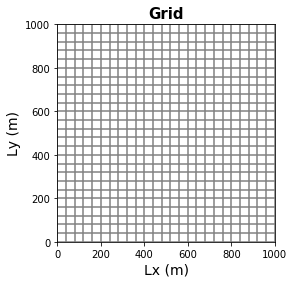

In [6]:
#CHECK GRID from DIS package
modelmap = flopy.plot.ModelMap(model=m, layer=0)
grid = modelmap.plot_grid() 
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Grid', fontsize = 15, fontweight = 'bold')
plt.show()

 <a name="III"></a>
### III. Assign Cell Activity/Starting Heads and Attach BAS Package

In [7]:
#create ibound as array of ints = 1
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32)

#create strt as array of floats = 1m
strt = np.ones((nlay, nrow, ncol), dtype=np.float32)

#create flopy bas object
bas = flopy.modflow.ModflowBas(m, ibound=ibound, strt=strt)

 <a name="IV"></a>
### IV. Define Layer Properties and Attach LPF Package

- For simplicity, we assign uniform layer properties as a single value to be applied to every cell.

In [8]:
#define layer properties 
laytyp = 1
hk = 1.0 #m/d
vka = 1.0 #m/d
sy = 0.1 #1/m
ss = 1.e-4 #1/m

#attach LPF package
lpf = flopy.modflow.ModflowLpf(model=m, hk=hk, vka=vka, sy=sy, ss=ss, laytyp=laytyp, ipakcb=53)


 <a name="V"></a>
## V. Assign Constant Head Boundaries and Attach CHD Package

- The CHD package simulates constant head cells, and is used to assign boundary conditions for this model rather than the ibound variable because the heads set in this package may be adjusted transiently. Each Constant Head cell takes the following assignments:

cdh_cell = [layer, row, column, shead, ehead] 

<strong>where:</strong> layer, row, column indicate the cell index and shead is the head in the cell at the start of the stress period and ehead is the head in the cell at the end of the stress period. If these are different, a linear interpolation is used to simulate head throughout time steps in the stress period. 

- Constant head cells are initiated during a stress period by putting them in the <strong> chd_spd </strong> variable which is set up as a dictionary of lists containing constant head info for each active cell during the stress period:

chd_spd = {stress period: [chd_cell(s)]}

(More info in flopy documentation: http://modflowpy.github.io/flopydoc/mfchd.html)


- Here, we define a boundary condition that will carry through all the stress periods by default, but it may be adjusted per stress period depending on what is most realistic for your model. 

In [9]:
#assign heads at start and end of stress period
strt_head=2
end_head=2
#create list to hold stress period constant head boundary condition cells
bound_sp1 = []

#assign constant head boundary cells on the left and right boundaries
for lay in range(nlay):
    for row in range(nrow):
        bound_sp1.append([lay,row,0,strt_head,end_head])
        bound_sp1.append([lay,row,ncol-1,strt_head,end_head])

print('Stress Period 1 CHD cells: \n',bound_sp1)

Stress Period 1 CHD cells: 
 [[0, 0, 0, 2, 2], [0, 0, 24, 2, 2], [0, 1, 0, 2, 2], [0, 1, 24, 2, 2], [0, 2, 0, 2, 2], [0, 2, 24, 2, 2], [0, 3, 0, 2, 2], [0, 3, 24, 2, 2], [0, 4, 0, 2, 2], [0, 4, 24, 2, 2], [0, 5, 0, 2, 2], [0, 5, 24, 2, 2], [0, 6, 0, 2, 2], [0, 6, 24, 2, 2], [0, 7, 0, 2, 2], [0, 7, 24, 2, 2], [0, 8, 0, 2, 2], [0, 8, 24, 2, 2], [0, 9, 0, 2, 2], [0, 9, 24, 2, 2], [0, 10, 0, 2, 2], [0, 10, 24, 2, 2], [0, 11, 0, 2, 2], [0, 11, 24, 2, 2], [0, 12, 0, 2, 2], [0, 12, 24, 2, 2], [0, 13, 0, 2, 2], [0, 13, 24, 2, 2], [0, 14, 0, 2, 2], [0, 14, 24, 2, 2], [0, 15, 0, 2, 2], [0, 15, 24, 2, 2], [0, 16, 0, 2, 2], [0, 16, 24, 2, 2], [0, 17, 0, 2, 2], [0, 17, 24, 2, 2], [0, 18, 0, 2, 2], [0, 18, 24, 2, 2], [0, 19, 0, 2, 2], [0, 19, 24, 2, 2], [0, 20, 0, 2, 2], [0, 20, 24, 2, 2], [0, 21, 0, 2, 2], [0, 21, 24, 2, 2], [0, 22, 0, 2, 2], [0, 22, 24, 2, 2], [0, 23, 0, 2, 2], [0, 23, 24, 2, 2], [0, 24, 0, 2, 2], [0, 24, 24, 2, 2]]


In [10]:
#create dictionary with stress period data
chd_spd={0: bound_sp1}

print('CHD Stress Period Data: \n', chd_spd)

CHD Stress Period Data: 
 {0: [[0, 0, 0, 2, 2], [0, 0, 24, 2, 2], [0, 1, 0, 2, 2], [0, 1, 24, 2, 2], [0, 2, 0, 2, 2], [0, 2, 24, 2, 2], [0, 3, 0, 2, 2], [0, 3, 24, 2, 2], [0, 4, 0, 2, 2], [0, 4, 24, 2, 2], [0, 5, 0, 2, 2], [0, 5, 24, 2, 2], [0, 6, 0, 2, 2], [0, 6, 24, 2, 2], [0, 7, 0, 2, 2], [0, 7, 24, 2, 2], [0, 8, 0, 2, 2], [0, 8, 24, 2, 2], [0, 9, 0, 2, 2], [0, 9, 24, 2, 2], [0, 10, 0, 2, 2], [0, 10, 24, 2, 2], [0, 11, 0, 2, 2], [0, 11, 24, 2, 2], [0, 12, 0, 2, 2], [0, 12, 24, 2, 2], [0, 13, 0, 2, 2], [0, 13, 24, 2, 2], [0, 14, 0, 2, 2], [0, 14, 24, 2, 2], [0, 15, 0, 2, 2], [0, 15, 24, 2, 2], [0, 16, 0, 2, 2], [0, 16, 24, 2, 2], [0, 17, 0, 2, 2], [0, 17, 24, 2, 2], [0, 18, 0, 2, 2], [0, 18, 24, 2, 2], [0, 19, 0, 2, 2], [0, 19, 24, 2, 2], [0, 20, 0, 2, 2], [0, 20, 24, 2, 2], [0, 21, 0, 2, 2], [0, 21, 24, 2, 2], [0, 22, 0, 2, 2], [0, 22, 24, 2, 2], [0, 23, 0, 2, 2], [0, 23, 24, 2, 2], [0, 24, 0, 2, 2], [0, 24, 24, 2, 2]]}


In [11]:
#create flopy CHD object, and attach to model
chd = flopy.modflow.ModflowChd(model=m, stress_period_data=chd_spd)

 <a name="VI"></a>
## VI. Define River Location & Properties and attach RIV Package

The MODFLOW simulation of a river may be visualized as the following:

<img src="https://i.imgur.com/Gqq3xuP.png" title="MODFLOW River Package" width=600px /></a>

A stage in the river is higher than the aquifer head in the cell directly below it, will induce ﬂow into the aquifer depending on the head difference between the river and the aquifer and conductance of the sediment bottom. If the reverse is true of the head and stage, water will ﬂow from the aquifer to the river. 

#### MODFLOW calculates flow between river and aquifer as the following:

<p style="margin-left: 70px">$Q_{flux} = C*\Delta H$</p>

Where:

<p style="margin-left: 70px"> $\Delta H = H_{river}-H_{aquifer}$ 

<p style="margin-left: 70px"> $C = \dfrac{k(dx*dy)}{t}$

And:

<p style="margin-left: 70px"> $C$ = Conductance   $(\dfrac{L^2}{T})$ 

<p style="margin-left: 70px"> $k$ = Conductivity of River Bed Sediment   $(\dfrac{L}{T})$

<p style="margin-left: 70px"> $dx$ = Cell width   $(L)$

<p style="margin-left: 70px"> $dy$ = Cell Length   $(L)$

<p style="margin-left: 70px"> $t$ = Thickness of River Bed Sediment   $(L)$ </p>

#### Specified Parameters:

Location, Conductance, River Bottom, and River Stage are all specified for each river cell in a MODFLOW model. In flopy, conductance is specified as <strong> cond </strong>, the river bottom is specified as <strong> rbot </strong> and river stage is specified as <strong> r_stage </strong>. Layer, Row, and Column of the river cell is also specified. 

- The RIV Package takes stress period data very similarly to the CHD package with river cell information defined in a list:

riv_cell = [layer, row, column, stage, conductance, bottom]

- And stress period data assigned in a dictionary of the form:

riv_spd = {stress period: [riv_cell(s)]}

(More info in flopy documentation: http://modflowpy.github.io/flopydoc/mfriv.html)


- Here, we define a column of river cells halfway across the domain and set the head in the river to fluctuate between 1 and 5 during the stress periods. 





In [12]:
#DEFINE RIVERS

#stress period 1 river cells
riv_sp1 = [] #create list to store all river cells for stress period 1
k_rivbott = 1 #river bottom hydraulic conductivity in m/d
sed_thick = 1 #thickness of riverbed sediment in m
cond = k_rivbott*(dy)*(dx)/(sed_thick) #river bed conductance in m^2/d
r_stage = 1 #stage in river (stress period 1)
r_bott = 0 #river bottom
#assign river data to cells in central column
for i in range(nrow):
    riv_sp1.append([0, i, ncol/2, r_stage, cond, r_bott])


#stress period 2 river cells
riv_sp2 = [] #create list to store all river cells for stress period 2
r_stage = 5 #stage in river (stress period 2)
for i in range(nrow):
    riv_sp2.append([0, i, ncol/2, r_stage, cond, r_bott])

#stress period 3 river cells
riv_sp3 = [] #create list to store all river cells for stress period 3
r_stage = 1 #stage in river (stress period 3)
for i in range(nrow):
    riv_sp3.append([0, i, ncol/2, r_stage, cond, r_bott])


#create dictionary of stress period data
riv_spd = {0: riv_sp1, 1: riv_sp2, 2: riv_sp3}

In [13]:
#attach river package
riv = flopy.modflow.ModflowRiv(model=m,stress_period_data = riv_spd)

### Check CHD and RIV Boundary Conditions

C:\Users\bigda\Anaconda3\lib\site-packages\flopy\plot\map.py:1415: PendingDeprecationWarning: ModelMap will be replaced by PlotMapView(); Calling PlotMapView()
  warnings.warn(err_msg, PendingDeprecationWarning)


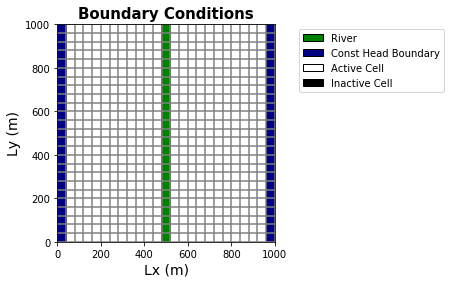

In [14]:
#CHECK BOUNDARY CONDITIONS
#use flopy to plot grid, ibound, rivers, and general head boundaries
modelmap = flopy.plot.ModelMap(model=m, layer=0)
grid = modelmap.plot_grid()
ib = modelmap.plot_ibound()
riv_plot = modelmap.plot_bc(ftype='RIV')
chd_plot = modelmap.plot_bc(ftype='CHD')
#add labels and legend
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Boundary Conditions', fontsize = 15, fontweight = 'bold')
plt.legend(handles=[mp.patches.Patch(color='green',label='River',ec='black'),
                   mp.patches.Patch(color='navy',label='Const Head Boundary',ec='black'),
                   mp.patches.Patch(color='white',label='Active Cell',ec='black'),
                   mp.patches.Patch(color='black',label='Inactive Cell',ec='black')],
                   bbox_to_anchor=(1.8,1.0))
plt.show(modelmap)

 <a name="VII"></a>
### VII. Specify Data Output and Attach OC Package

In [15]:
#create OC stress period data
oc_spd = {}
for kper in range(nper):
    for kstp in range(nstp[kper]):
        oc_spd[(kper, kstp)] = ['save head',
                                            'save drawdown',
                                            'save budget',
                                            'print head',
                                            'print budget']
oc = flopy.modflow.ModflowOc(model=m, stress_period_data=oc_spd,
                             compact=True)
print('Output Control \n', oc_spd)

Output Control 
 {(0, 0): ['save head', 'save drawdown', 'save budget', 'print head', 'print budget'], (1, 0): ['save head', 'save drawdown', 'save budget', 'print head', 'print budget'], (1, 1): ['save head', 'save drawdown', 'save budget', 'print head', 'print budget'], (1, 2): ['save head', 'save drawdown', 'save budget', 'print head', 'print budget'], (1, 3): ['save head', 'save drawdown', 'save budget', 'print head', 'print budget'], (1, 4): ['save head', 'save drawdown', 'save budget', 'print head', 'print budget'], (1, 5): ['save head', 'save drawdown', 'save budget', 'print head', 'print budget'], (1, 6): ['save head', 'save drawdown', 'save budget', 'print head', 'print budget'], (1, 7): ['save head', 'save drawdown', 'save budget', 'print head', 'print budget'], (1, 8): ['save head', 'save drawdown', 'save budget', 'print head', 'print budget'], (1, 9): ['save head', 'save drawdown', 'save budget', 'print head', 'print budget'], (2, 0): ['save head', 'save drawdown', 'save bu

<a name="VIII"></a>
### VIII. Assign PCG as Finite Difference Solver and Attach PCG Package

In [16]:
#assign groundwater flow solver
pcg = flopy.modflow.ModflowPcg(model=m)

 <a name="IX"></a>
### IX. Create MODFLOW files and Run Model

In [17]:
#write MODFLOW input files
m.write_input()

In [18]:
# Run the model
success, mfoutput = m.run_model(pause=False, report=True)
if not success:
    raise Exception('MODFLOW did not terminate normally.')

FloPy is using the following  executable to run the model: C:\Users\bigda\Desktop\G572\FloPyTutorials\modflowdir\mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: my_river_model.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2019/12/24 12:06:39

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Str

<a name="X"></a>
### X. Extract Head and Flow Data 

In [19]:
#extract binary data from head file
times = [perlen[0],perlen[0]+perlen[1],perlen[0]+perlen[1]+perlen[2]] #extract times at end of each stress period
head = {} #create dictionary to store head data at end of each stress period
frf = {} #create dictionary to store flows through right cell face at end of each stress period
fff = {} #create dictionary to store flows through front cell face at end of each stress period
headobj = flopy.utils.binaryfile.HeadFile(modelname+'.hds') #get head data as python object
budgobj = flopy.utils.binaryfile.CellBudgetFile(modelname+'.cbc') #get flow data as python object

#get data from python objects
for stress_per, time in enumerate(times): #iterate through times at end of each stress period
    head['sp%s'%(stress_per)] = headobj.get_data(totim=time) #append heads to head list for ea stress per
    frf['sp%s'%(stress_per)] = budgobj.get_data(text='FLOW RIGHT FACE',totim=time) #append right face flow to frf list for ea stress per
    fff['sp%s'%(stress_per)] = budgobj.get_data(text='FLOW FRONT FACE',totim=time) #append front face flow to fff list for ea stress per


<a name="XI"></a>
## XI. Plotting

### Head Contour and Flow Plots

C:\Users\bigda\Anaconda3\lib\site-packages\flopy\plot\map.py:1415: PendingDeprecationWarning: ModelMap will be replaced by PlotMapView(); Calling PlotMapView()
  warnings.warn(err_msg, PendingDeprecationWarning)


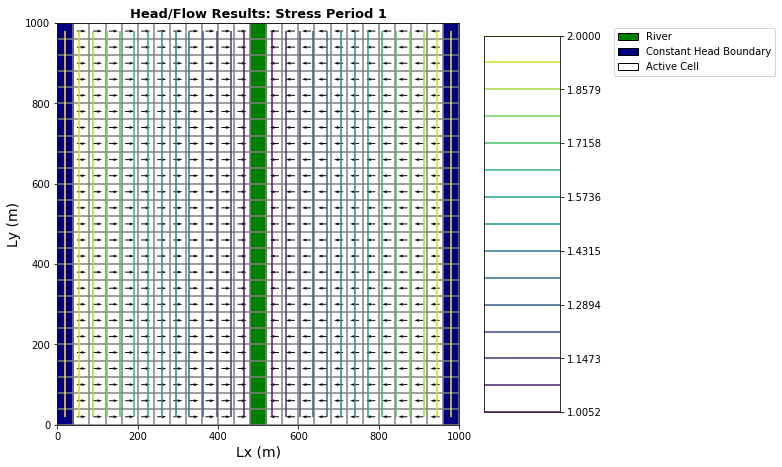

C:\Users\bigda\Anaconda3\lib\site-packages\flopy\plot\map.py:1415: PendingDeprecationWarning: ModelMap will be replaced by PlotMapView(); Calling PlotMapView()
  warnings.warn(err_msg, PendingDeprecationWarning)


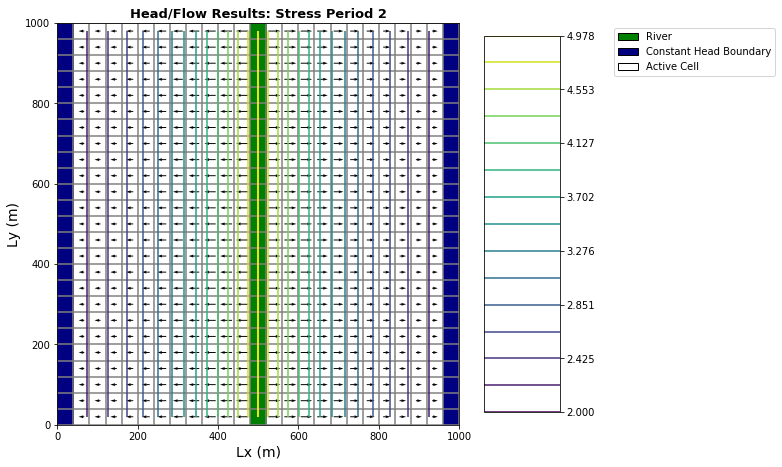

C:\Users\bigda\Anaconda3\lib\site-packages\flopy\plot\map.py:1415: PendingDeprecationWarning: ModelMap will be replaced by PlotMapView(); Calling PlotMapView()
  warnings.warn(err_msg, PendingDeprecationWarning)


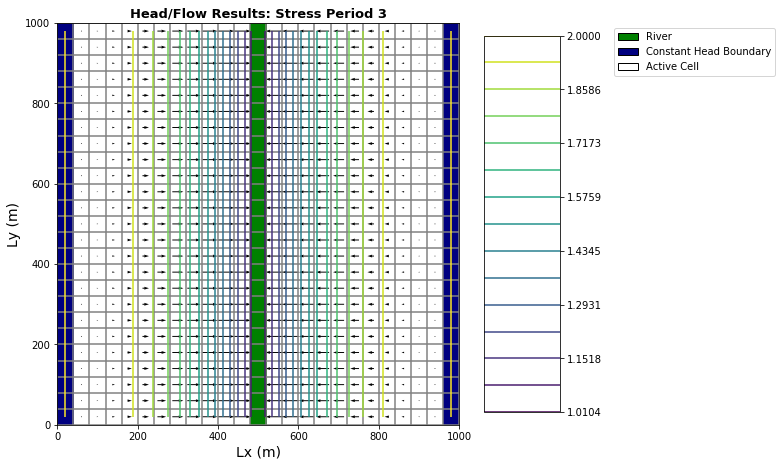

In [20]:
#plot results for all stress periods
for i in range(len(times)):
    plt.figure(figsize=(9,9)) #create 10 x 10 figure
    modelmap = flopy.plot.ModelMap(model=m, layer=0) #use modelmap to attach plot to model
    grid = modelmap.plot_grid() #plot model grid
    riv_plot = modelmap.plot_bc(ftype='RIV') #plot river cells
    chd_plot = modelmap.plot_bc(ftype='CHD') #plot ghb cells
    contour_levels = np.linspace(head['sp%s'%i][0].min(),head['sp%s'%i][0].max(),15) #set contour levels for contouring head
    head_contours = modelmap.contour_array(head['sp%s'%i][0], levels=contour_levels) #create head contours
    flows = modelmap.plot_discharge(frf['sp%s'%i][0], fff['sp%s'%i][0], head=head['sp%s'%i]) #create discharge arrows
    
    #display parameters
    plt.xlabel('Lx (m)',fontsize = 14)
    plt.ylabel('Ly (m)',fontsize = 14)
    plt.title('Head/Flow Results: Stress Period %s'%(i+1), fontsize = 13, fontweight = 'bold')
    plt.colorbar(head_contours, aspect=5)
    plt.legend(handles=[mp.patches.Patch(color='green',label='River',ec='black'), 
                   mp.patches.Patch(color='navy',label='Constant Head Boundary',ec='black'),
                   mp.patches.Patch(color='white',label='Active Cell',ec='black')],
                   bbox_to_anchor=(1.8,1.0)) #create legend
    plt.show(modelmap)

### 3D Head Surface Plots

<strong> Note: </strong> Flopy takes cell indexing where the top left of the grid is the (0,0) cell index while the Length & Width units start at 0 in the lower left of the grid. This seems a little wierd, but it makes it easy to match up an array of cell by cell numbers to their respective locations on the grid when assigning properties or observing output data. Flopy's plotting capabilities automatically flip the resultant head data to display on its proper grid, however, for the 3d plots below, you'll see the function np.flipud() is used to flip the data array to plot in the same direction.

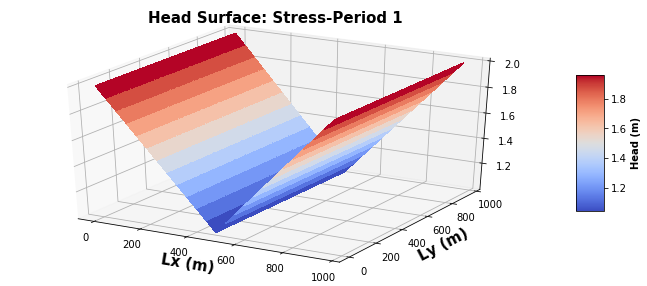

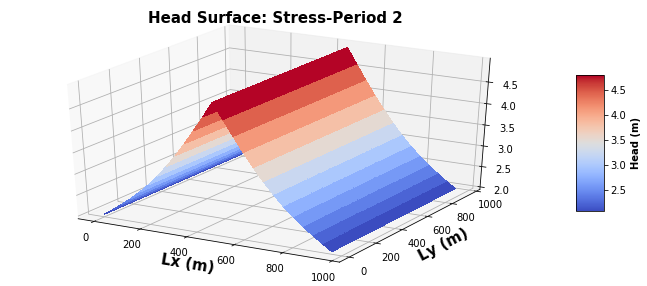

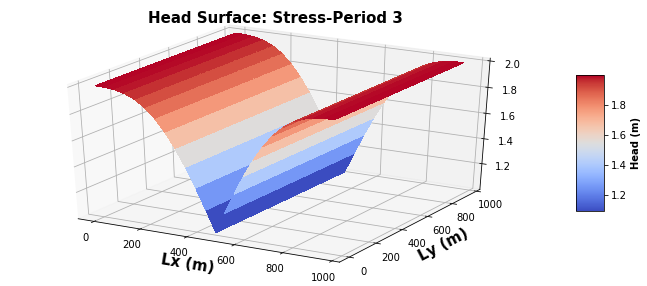

In [21]:
#import 3d axes toolkit from matplotlib
from mpl_toolkits.mplot3d import Axes3D

#set X, Y, Z variables for 3d plot to be our model domain and head solution
X = np.arange(0,Lx,dx)
Y = np.arange(0,Ly,dy)
X, Y = np.meshgrid(X, Y)

#create a figure for every time
for i in range(len(times)):
    #create 3d figure
    fig_3d = plt.figure(figsize=(12,5)) #create a figure instance
    ax = fig_3d.gca(projection='3d') #set an axes with 3d properties
    Z = np.flipud(head['sp%s'%i][0]) #head matrix is flipped to display properly 

    #create surface and labels
    surf = ax.plot_surface(X,Y,Z, cmap = plt.cm.coolwarm, linewidth=0, antialiased=False, label='head') #plot head surface
    fig_3d.colorbar(surf,shrink=0.5,aspect=5).set_label('Head (m)',fontsize=10,fontweight='bold') #set colorbar
    ax.set_xlabel('Lx (m)', fontsize=15, fontweight='bold')
    ax.set_ylabel('Ly (m)', fontsize=15, fontweight='bold')
    ax.set_title('Head Surface: Stress-Period %s'%(i+1), fontsize=15, fontweight='bold')
    plt.show(surf)

- Notice the difference between the plots for Stress-Periods 1 and 3: They both have the same boundary conditions, however, plot 1 displays the steady-state solution, whereas plot 3 represents conditions that have not entirely relaxed to the steady-state drawdown. Increasing the length (perlen) of this last stress period should yield a head surface that looks more similar to stress period 1.

### Time Series Plot of Head at Single Cell

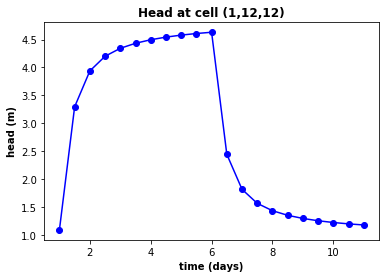

Time Series Head Data: 
 [[ 1.         1.0880829]
 [ 1.5        3.2954612]
 [ 2.         3.9382052]
 [ 2.5        4.2017574]
 [ 3.         4.343931 ]
 [ 3.5        4.4343276]
 [ 4.         4.497604 ]
 [ 4.5        4.5445633]
 [ 5.         4.5807242]
 [ 5.5        4.6092424]
 [ 6.         4.632088 ]
 [ 6.5        2.4432013]
 [ 7.         1.8155264]
 [ 7.5        1.56431  ]
 [ 8.         1.4322644]
 [ 8.5        1.3502005]
 [ 9.         1.2937887]
 [ 9.5        1.252489 ]
 [10.         1.2209972]
 [10.5        1.196332 ]
 [11.         1.1766671]]


In [22]:
#plot a time series at cell left of river
#get time series for cell
cell_id = (0, int(nrow/2) - 1, int(ncol/2) - 1) #specify which cell we're interested in (cell at center of model)
time_series = headobj.get_ts(cell_id) #get the time series using flopy

#create plot
plt.subplot(1, 1, 1)
plt.title('Head at cell ({0},{1},{2})'.format(cell_id[0] + 1, 
                                              cell_id[1] + 1, 
                                              cell_id[2] + 1),fontweight='bold') #create title with cell_id format
plt.xlabel('time (days)',fontweight='bold')
plt.ylabel('head (m)',fontweight='bold')
plt.plot(time_series[:, 0], time_series[:, 1], 'bo-') #plot the time series with points at each record
plt.show()
print('Time Series Head Data: \n', time_series) #print the time series data